# Model-based Reinforcement Learning

In the context of dynamic programming, algorithms **require a model** of the environment and they calculate optimal policies offline, on the other hand, in the reinforcement learning we presented several **model-free** learning methods. The advantage of model-free methods is that they doesn’t require information about the MDP internals. Often the MDP is challenging to obtain in advance or it is even impossible to obtain: imagine to represents the game of Go with its 10.170 possible states or the StarCraft II game with 101.685 states. Not requiring the MDP in advance is a of crucial importance. However, what if we don’t require the MDP in advance, but perhaps we **learn one as we interact** with the environment? We can imagine agents that interact with the environment (like the model-free methods) and also learn a model of the environment from these interactions and use that model to improve their behavior (line dynamic programming). We call this second phase **plannig**, since it is not base on interaction. By exploiting the learned model, agents often require fewer experience samples to learn optimal policies. These methods are called **model-based reinforcement learning**. We use again the **Slippery Walk** environment. Remember, it is a walk, a single-row slippery (stochastic) grid-world environment, with seven non-terminal states. If the agent chooses to go left, there is a chance it does, but there is also a chance that it goes right, or that it stays in place:

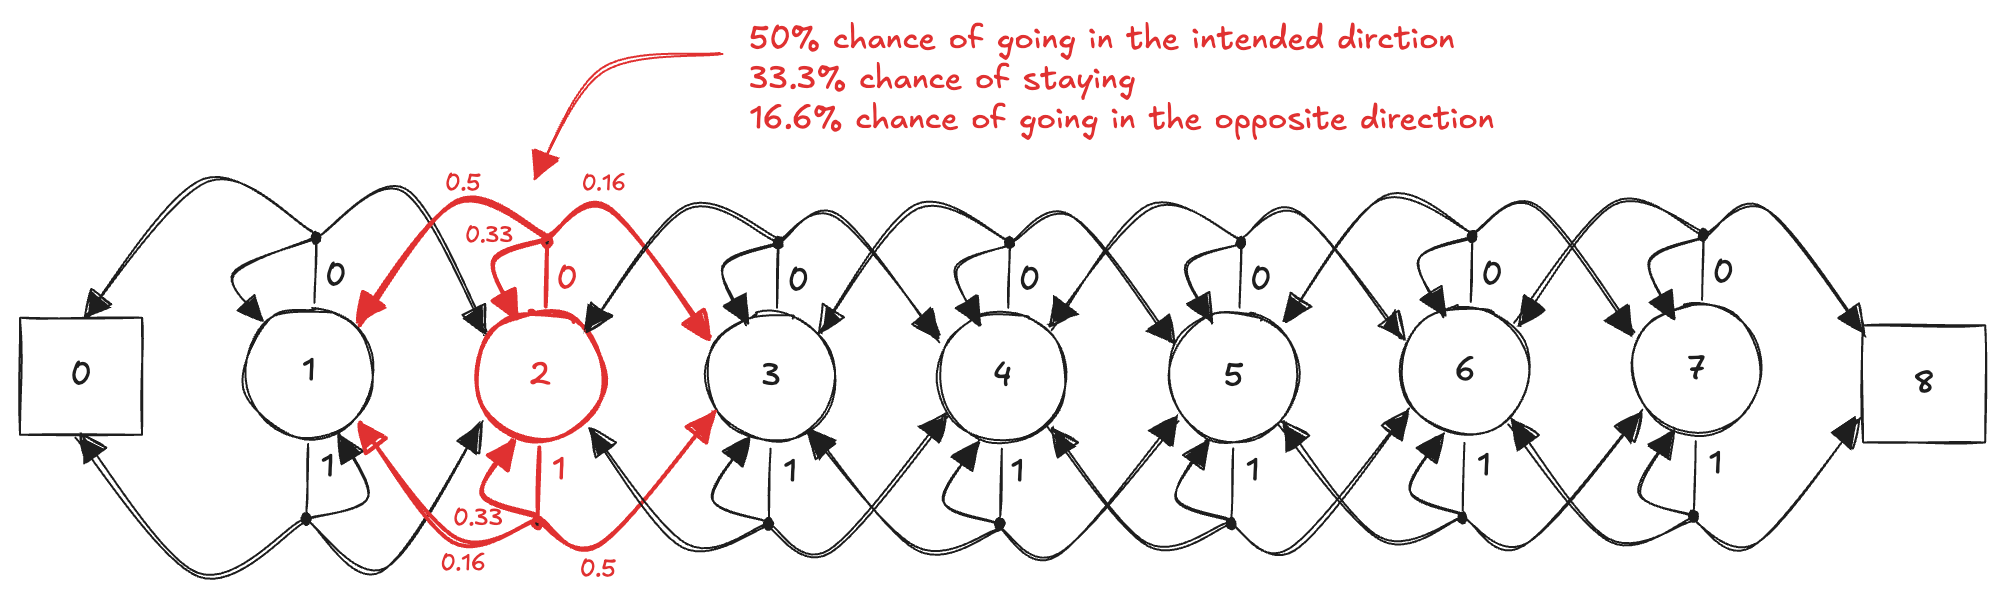

In [1]:
import random
import numpy as np
        
class SlipperyWalk:
    def __init__(self):
        self.reset();

    def reset(self):
        self.observation_space = 9;
        self.action_space = 2;
        self.state = np.random.choice([1,2,3,4,5,6,7]);
        self.terminated = False;
        return self.state;

    def step(self, action):
        if self.terminated: raise ValueError('Episode has terminated');
        if action not in [0, 1]: raise ValueError('Invalid action');
        
        if(action==0): direction = -1;
        if(action==1): direction = 1;
        
        direction_list = [direction, -direction, 0];
        true_direction = random.choices(direction_list, weights=(50, 17, 33), k=1);
        self.state += true_direction[0];
        
        reward = 0
        if self.state < 1: self.terminated = True;
        if self.state > 7: self.terminated = True; reward = 1;
        return self.state, reward, self.terminated, 0, 0;

In [2]:
slippery_walk = SlipperyWalk();
optimal_v = [0., 0.5637, 0.763, 0.8449, 0.8892, 0.922, 0.9515, 0.9806, 0.];

## Learning sample models: Dyna-Q

Dyna-Q ([Richard S. Sutton, "Dyna, an integrated architecture for learning, planning, and reacting", ACM SIGART Bulletin, 1991](./papers/1991%20-%20Dyna,%20an%20integrated%20architecture%20for%20learning,%20planning,%20and%20reacting.pdf)) consists of **interleaving a model-free method** (like Q-learning) and **a model-based method** (like value iteration), using both experiences sampled from the environment and experiences sampled from the learned model to improve the action-value function:

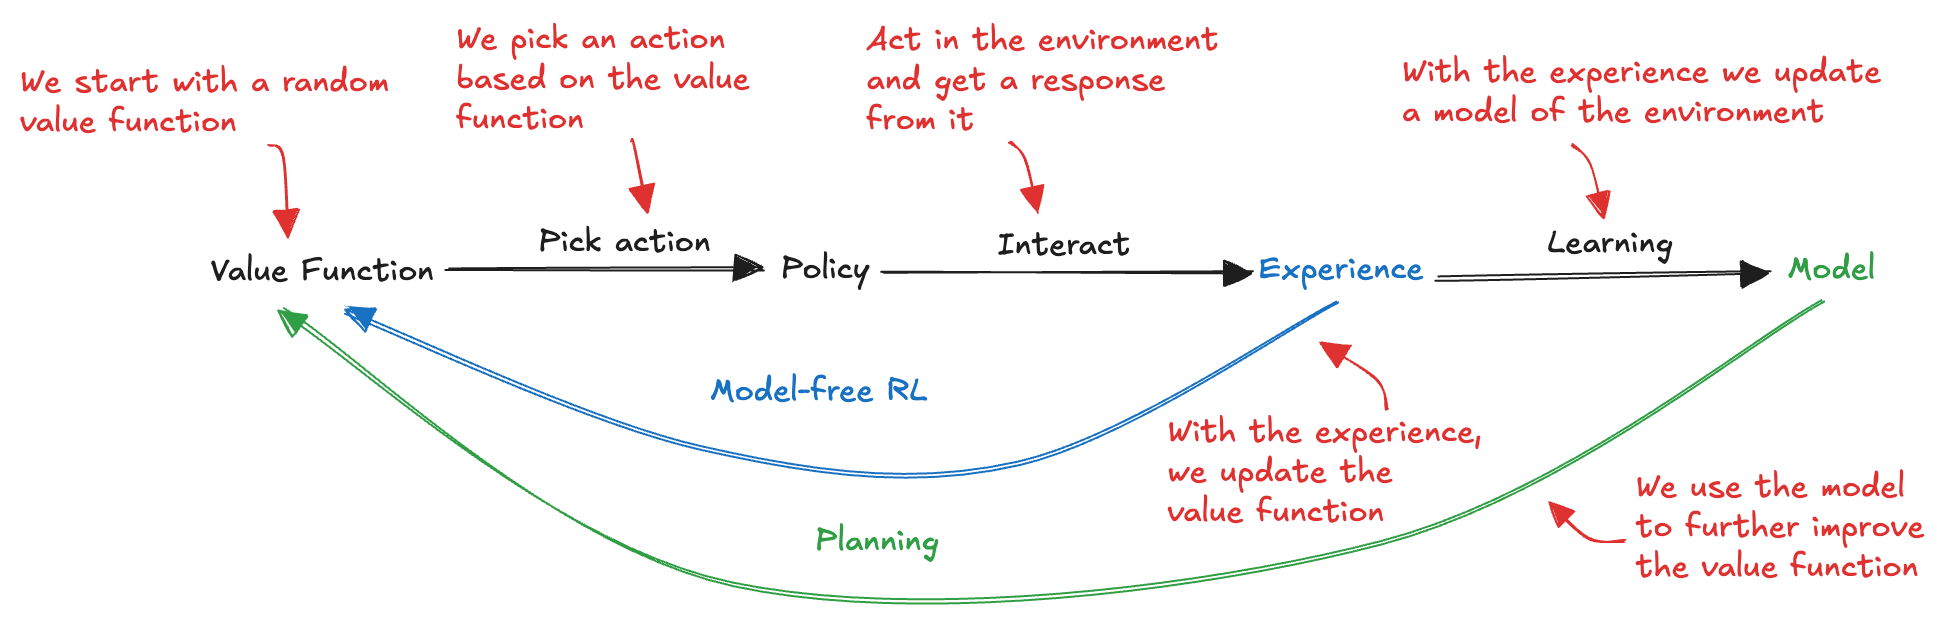

We keep track of the transition and reward functions as three-dimensional tensors indexed by state, action, and next state. The transition tensor keeps count of the number of times we’ve seen the tuple (state, action, next state) indicating how many times we arrived at the next state from the state when selecting that action. The reward tensor holds the average reward we received on the tuple (state, action, next state) indicating the expected reward when we select the action on that state and transition to the next state. To implement the Dyna-Q, we need to decay alpha and epsilon, using the same function already used several times:

In [3]:
def decay_schedule(init_value, min_value, decay_steps, max_steps):

    # calculate the number of the remaining steps after the decay
    rem_steps = max_steps - decay_steps;

    # logspace returns numbers spaced evenly on a log scale
    # base^start is the starting value of the sequence,
    # base^stop is the final value of the sequence
    # num is the number of values to generate
    # base is the base of the log space
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10);

    # because the values may not end exactly at 0, given it’s the log, 
    # we change them to be between 0 and 1 so that the curve looks smooth and nice.
    values = (values - values.min()) / (values.max() - values.min());

    # linear transformation and get points between init_value and min_value
    values = (init_value - min_value) * values + min_value;

    # repeats the rightmost value rem_step number of times
    values = np.pad(values, (0, rem_steps), 'edge');

    return values;

And again we use need to explore and we can use the decaying epsilon-greedy approach to control the exploration:

In [4]:
def select_action(state, q, epsilon=0.1):

    # if the random number is greater than epsilon, 
    if np.random.uniform() > epsilon:
        # pick the action with the highest Q value
        action = np.argmax(q[state]);
    else:
        # otherwise, pick a random action
        action = np.random.randint(len(q[0]));

    return action;

The we can implement the Dyna-Q algorithm:

In [ ]:
def dyna_q(env, gamma=0.99,
           init_alpha=0.5, min_alpha=0.01, 
           init_epsilon=1.0, min_epsilon=0.1, 
           n_planning=3,
           decay_episodes=1000, n_episodes=3000):
    
    # calculate the learning rate schedule for all episodes    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);

    # calculate epsilon for all episodes   
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes);

    # initialize the current estimate of the action-value function
    q = np.zeros((env.observation_space, env.action_space), dtype=float);

    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space), dtype=float);

    # create a function to keep track of the transition function
    # and another one to keep track of the reward signal.
    transitions = np.zeros((env.observation_space, env.action_space, env.observation_space), dtype=int);
    rewards = np.zeros((env.observation_space, env.action_space, env.observation_space), dtype=float);

    # create a list to save copies of the model and of the planning 
    # for offline analysis
    transitions_track = [];
    planning_track = [];
    
    # the episode loop
    for e in range(n_episodes):
                   
        # we start episode by resetting the environment and the done flag
        state, done = env.reset(), False;
        
        # repeat until we hit a terminal state
        while not done:
                   
            # select the action, as in Q-learning       
            action = select_action(state, q, epsilons[e]);
                   
            # step the environment using that action
            next_state, reward, terminated, truncated, info = env.step(action);
            if(terminated or truncated):
                done = True;

            # start learning the model 
            # increment the transition count for the state-action-next_state triplet 
            transitions[state][action][next_state] += 1;
            
            # calculate an incremental mean of the reward signal
            # and use it to learn the reward signal
            difference = reward - rewards[state][action][next_state];
            rewards[state][action][next_state] += (difference / transitions[state][action][next_state]);

            # calculate the target as usual in Q-learning!
            # (off-policy, using the max)
            dyna_target = reward + gamma * q[next_state].max();
            
            # calculate the error 
            dyna_error = dyna_target - q[state][action];
            
            # update the action-value function
            q[state][action] = q[state][action] + alphas[e] * dyna_error;

            # get into the planning steps, first back up the next state variable      
            backup_next_state = next_state;
            
            # planning loop
            for _ in range(n_planning):
                   
                # make sure there have been updates to the Q-function before, 
                # otherwise, there’s not much to plan
                if q.sum() == 0: 
                    break;

                # select a state from a list of states already visited by 
                # the agent in experience   
                visited_states = np.where(np.sum(transitions, axis=(1, 2)) > 0)[0];
                state = np.random.choice(visited_states);

                # then select an action that has been taken on that state   
                actions_taken = np.where(np.sum(transitions[state], axis=1) > 0)[0];
                action = np.random.choice(actions_taken);

                # use the transitions to calculate probabilities of a next state 
                # and then a next state   
                probs = transitions[state][action]/transitions[state][action].sum();
                next_state = np.random.choice(np.arange(env.observation_space), size=1, p=probs)[0];
                
                # use the rewards model as the reward
                reward = rewards[state][action][next_state];

                # save the plannig decistion for offline analysis
                planning_track.append((state, action, reward, next_state));

                # update the Q-function using that simulated experience!    
                dyna_target = reward + gamma * q[next_state].max();
                dyna_error = dyna_target - q[state][action];
                q[state][action] = q[state][action] + alphas[e] * dyna_error;
                        
            # at the end of the planning, set the state as the next state
            state = backup_next_state;
        
        # extract the state-value function   
        v = np.max(q, axis=1);

        # and the greedy policy
        def pi(s):
            return np.argmax(q[s]);

        # save the value functions and the transitions model for analysis 
        v_track[e] = v;
        transitions_track.append(transitions.copy());

    return q, v, pi, v_track, transitions_track, np.array(planning_track);

We can apply DynaQ to the Slippery Walk environment and try to understand the  model learned by the algorithm.

In [85]:
q_dyna, v_dyna, pi_dyna, v_track_dyna, transitions_track_dyna, planning_dyna = dyna_q(slippery_walk)

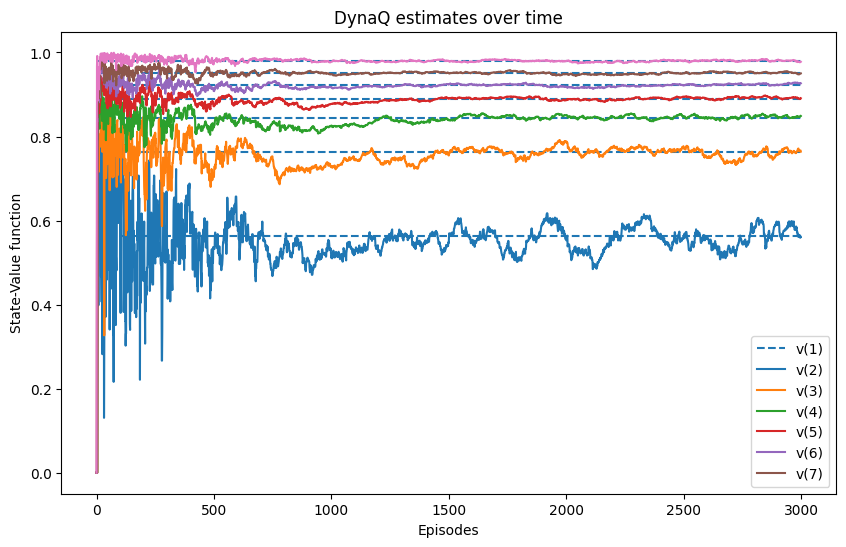

In [86]:
import matplotlib.pyplot as plt
legends = ['v(1)','v(2)','v(3)','v(4)','v(5)', 'v(6)', 'v(7)'];
plt.figure(figsize=(10,6));
plt.hlines(optimal_v[1:8], 0, 3000, linestyle='--');
plt.plot(v_track_dyna[:,1:8]);
plt.title('DynaQ estimates over time');
plt.ylabel('State-Value function');
plt.xlabel('Episodes');
plt.legend(legends);
plt.show();

Dyna-Q can **learn an optimal policy much faster** than model-free methods, this is because it can learn from both real and simulated experiences. This is particularly important in applications where interacting with the environment is expensive or time-consuming, such as robotics. Of course, the performance is dependent on the accuracy of its learned model. If the model is inaccurate, the agent may make poor decisions. This is especially problematic in changing environments, where the model needs to be constantly updated. Moreover, planning can be computationally expensive. In order to check the model of the einvironment learned by DynaQ,  we can plot a 3D graph of the transitions at different episodes . The axis to the right is the initial state, the axis to the left is the landing state, the colors are the actions, and bar heights are the transition probabilities.

In [90]:
def plot_transition_model(transitions):

    np.seterr(divide='ignore', invalid='ignore');
    
    transitions_prob = transitions / transitions.sum(axis=2, keepdims=True);
    
    fig = plt.figure(figsize=(20,12));
    ax = fig.add_subplot(111, projection='3d');
    ax.view_init(elev=20, azim=50);
    
    plt.title('Learned MDP');
    ax.set_xlabel('Landing state');
    ax.set_ylabel('Initial state');
    ax.set_zlabel('Transition probabilities');
    ax.set_zlim(0, 1);

    x_data, y_data = np.meshgrid(range(transitions.shape[0]), range(transitions.shape[0]));
    x_data = x_data.flatten();
    y_data = y_data.flatten();
    left_data = transitions_prob[:, 0, :].flatten();
    right_data = transitions_prob[:, 1, :].flatten();

    ax.bar3d(x_data, y_data, np.zeros_like(left_data), 0.2, 0.2, left_data, color='yellow', shade=True);
    ax.bar3d(x_data, y_data, left_data, 0.2, 0.2, right_data, color='red', shade=True);
   

    left_proxy = plt.Rectangle((0, 0), 1, 1, fc='yellow');
    right_proxy = plt.Rectangle((0, 0), 1, 1, fc='red');
    plt.legend((left_proxy, right_proxy), ('Left', 'Right'));

    plt.show();

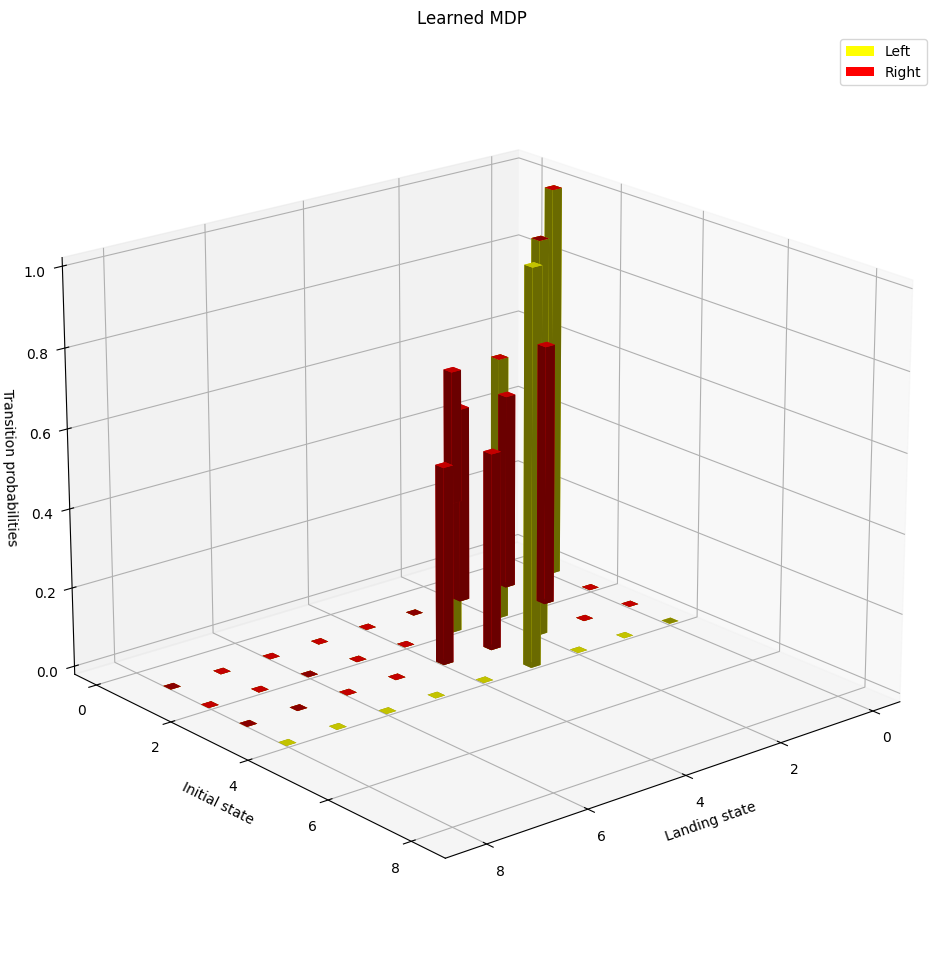

In [91]:
plot_transition_model(transitions_track_dyna[0]);

This is the model that Dyna-Q has learned after one episode. There are obvious issues with this model, but also, this is only after a single episode. This could mean trouble when using the learned model early on because there will be a bias when sampling an incorrect model.

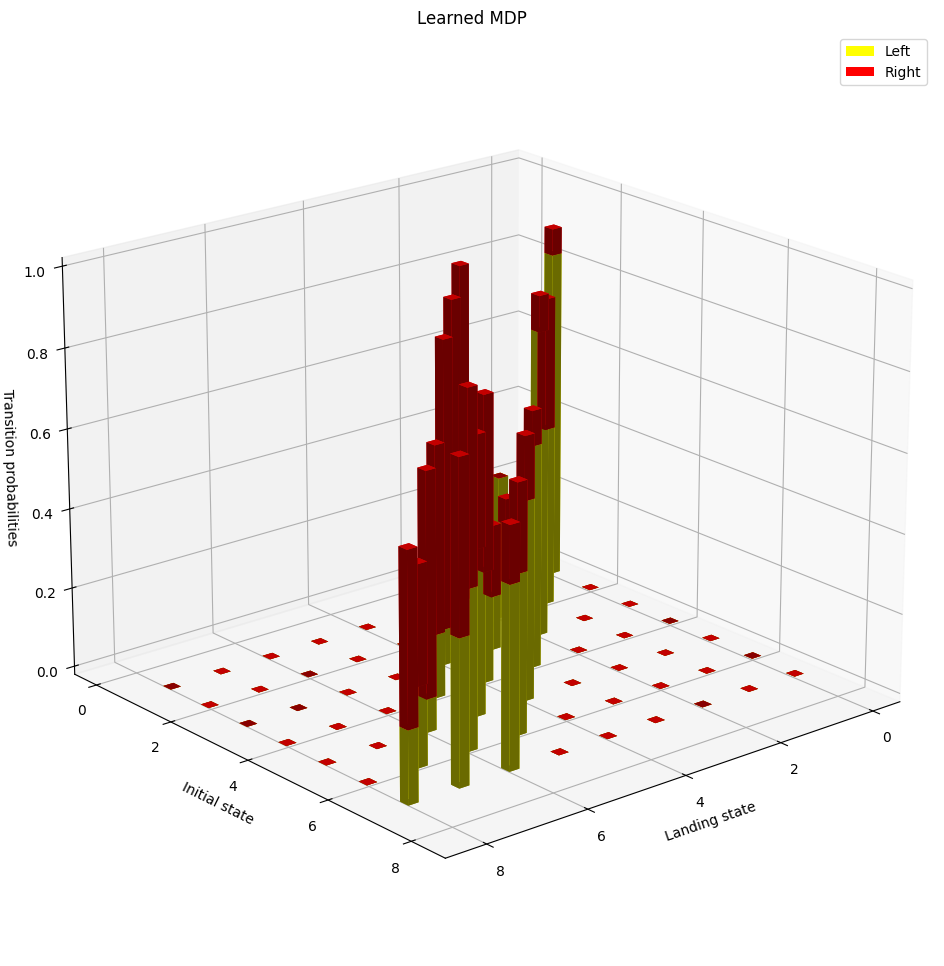

In [92]:
plot_transition_model(transitions_track_dyna[10]);

Only after 10 episodes, we can see the model taking shape. We can see the right probabilities coming together. 

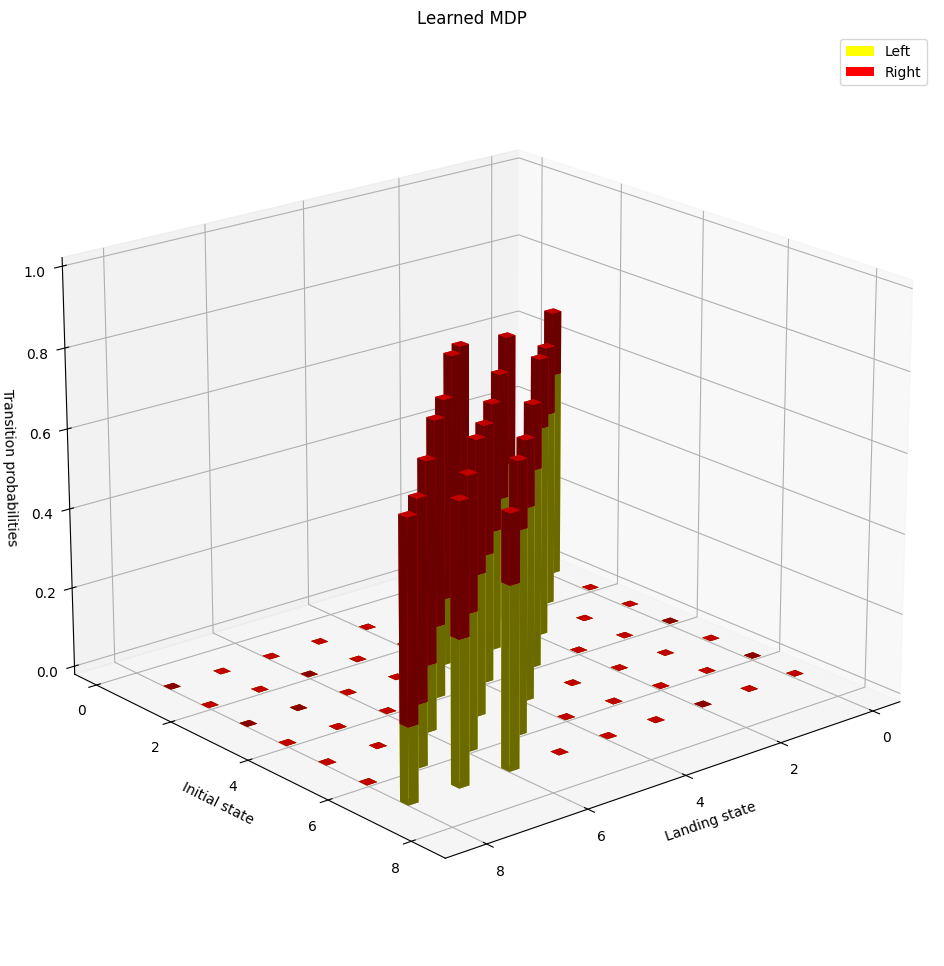

In [93]:
plot_transition_model(transitions_track_dyna[len(transitions_track_dyna)-1]);

At the end, the probabilities are good enough and describe the MDP correctly. Obviously, this is a simple environment, so the agent can gather enough experience samples for building an MDP quickly.

## Making plans for the immediate future: Trajectory sampling

During planning in DynaQ, we sample a state uniformly from the state-action pairs that have been visited (so we don’t waste time with state-action pairs about which the model has no information) and then we sample uniformly an action from previously selected actions. This point can be more effective if we used **a state that we expect to encounter during the current episode** and if **sample actions from the same behavioral policy (on policy) or from a greedy policy with respect to the current estimates (off policy)** at the given time step. This is what **Trajectory sampling** does ([A.G. Barto, S.J. Bradtke, S.P. Singh, "Learning to act using real-time dynamic programming", Artificial intelligence, 1995](./papers/1995%20-%20Learning%20to%20act%20using%20real-time%20dynamic%20programming.pdf). We can implement it in Python. For the most part, the code is the same as Dyna-Q, with a few exceptions:

In [ ]:
def trajectory_sampling(env, gamma=0.99, 
                        init_alpha=0.5, min_alpha=0.01, 
                        init_epsilon=1.0, min_epsilon=0.1, 
                        n_planning=3, 
                        decay_episodes=1000, n_episodes=3000):

    # calculate the learning rate schedule for all episodes    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);

    # calculate epsilon for all episodes   
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes);

    # initialize the current estimate of the action-value function
    q = np.zeros((env.observation_space, env.action_space), dtype=float);

    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space), dtype=float);

    # create a function to keep track of the transition function
    # and another one to keep track of the reward signal.
    transitions = np.zeros((env.observation_space, env.action_space, env.observation_space), dtype=int);
    rewards = np.zeros((env.observation_space, env.action_space, env.observation_space), dtype=float);

    # create a list to save copies of the model and of the planning 
    # for offline analysis
    transitions_track = [];
    planning_track = [];

    # the episode loop
    for e in range(n_episodes):
                   
        # we start episode by resetting the environment and the done flag
        state, done = env.reset(), False;
        
        # repeat until we hit a terminal state
        while not done:

            # select the action, as in Q-learning  
            action = select_action(state, q, epsilons[e])

            # step the environment using that action
            next_state, reward, terminated, truncated, info = env.step(action);
            if(terminated or truncated):
                done = True;
            
            # start learning the model 
            # increment the transition count for the state-action-next_state triplet 
            transitions[state][action][next_state] += 1;

            # calculate an incremental mean of the reward signal
            # and use it to learn the reward signal
            difference = reward - rewards[state][action][next_state];
            rewards[state][action][next_state] += (difference / transitions[state][action][next_state]);

            # calculate the target as usual in Q-learning!
            # (off-policy, using the max)
            ts_target = reward + gamma * q[next_state].max();
            
            # calculate the error 
            ts_error = ts_target - q[state][action];

            # update the action-value function
            q[state][action] = q[state][action] + alphas[e] * ts_error;
            
            # get into the planning steps, first back up the next state variable 
            backup_next_state = next_state;

            # planning loop
            for _ in range(n_planning):
                
                # make sure there have been updates to the Q-function before, 
                # otherwise, there is not much to plan
                if q.sum() == 0: 
                    break;

                # select the action following the behavioral policy or from the greedy policy
                # action = select_action(state, q, epsilons[e]);
                action = q[state].argmax();
                    
                # if we haven't experienced the transition, 
                # planning would be a mess, so break out
                if not transitions[state][action].sum(): 
                    break;

                # otherwise, get the probabilities of next_state and sample 
                # the model accordingly, as in DynaQ
                probs = transitions[state][action]/transitions[state][action].sum();
                next_state = np.random.choice(np.arange(env.observation_space), size=1, p=probs)[0];
                    
                # get the reward as prescribed by the reward-signal model, as in DynaQ
                reward = rewards[state][action][next_state];

                # save the plannig decistion for offline analysis
                planning_track.append((state, action, reward, next_state));

                # update the Q-function using that simulated experience!      
                ts_target = reward + gamma * q[next_state].max();
                ts_error = ts_target - q[state][action];
                q[state][action] = q[state][action] + alphas[e] * ts_error;

                # we update the state variable before we loop and 
                # continue the planning steps
                state = next_state;

            # at the end of the planning, set the state as the next state
            state = backup_next_state;
        
        # extract the state-value function 
        v = np.max(q, axis=1);
        
        # and the greedy policy
        def pi(s):
            return np.argmax(q[s]);
            
        # save the value functions and the transitions model for analysis 
        v_track[e] = v;
        transitions_track.append(transitions.copy());
    
    return q, v, pi, v_track, transitions_track, np.array(planning_track);

We apply the new algorithm to the Slippery Walk environment:

In [95]:
q_ts, v_ts, pi_ts, v_track_ts, transitions_track_ts, planning_ts = trajectory_sampling(slippery_walk);

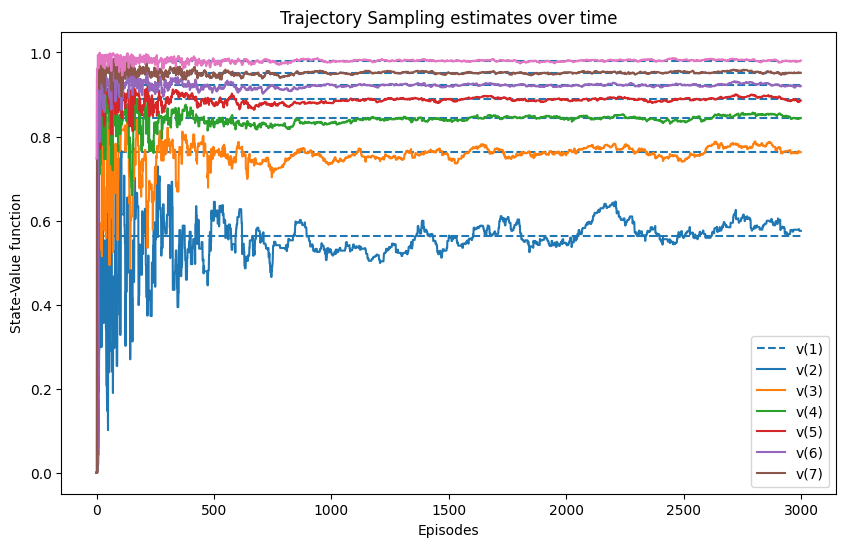

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6));
plt.hlines(optimal_v[1:8], 0, 3000, linestyle='--');
plt.plot(v_track_ts[:,1:8]);
plt.title('Trajectory Sampling estimates over time');
plt.ylabel('State-Value function');
plt.xlabel('Episodes');
plt.legend(legends);

plt.show();

The uniform sampling of Dyna-Q encourages more exploration, potentially leading to the discovery of novel strategies or shortcuts. However, this can also make it less efficient in exploiting already known rewarding paths. Trajectory Sampling, with its focus on the current policy, prioritizes exploitation, leading to faster convergence to a good (though not necessarily optimal) policy. Dyna-Q, due to its reliance on a less focused sampling strategy, can be more sensitive to model inaccuracies, especially in the early stages of learning. Sampling from poorly explored regions with an inaccurate model might lead to poor decision-making. Trajectory Sampling, being more focused on frequently encountered states, is less likely to be affected by inaccuracies in less visited parts of the model. In dynamic environments, Dyna-Q exploration might prove beneficial as it can lead to the discovery of new paths or rewards. However, its uniform sampling might make it slower to adapt to changes compared to Trajectory Sampling, which quickly focuses on relevant trajectories under the updated policy. We can compare the sampling differences by plotting the states that were sampled by the planning phase of the two algorithms and the actions selected in those states: 

In [100]:
def plot_state_action_sampling(planning, algo):
    plt.figure(figsize=(10,6));
    plt.title('States samples from {}'.format(algo));
    plt.xlabel('Initial states sampled',);
    plt.ylabel('Count');
    plt.legend(['Left', 'Right']);
    for s in np.arange(9):
        actions = planning[np.where(planning[:,0]==s)[0], 1];
        left = len(actions[actions == 0]);
        right = len(actions[actions == 1]);
        plt.bar(s, right, 0.2, color='yellow');
        plt.bar(s, left, 0.2, color='red', bottom=right);
    plt.show();

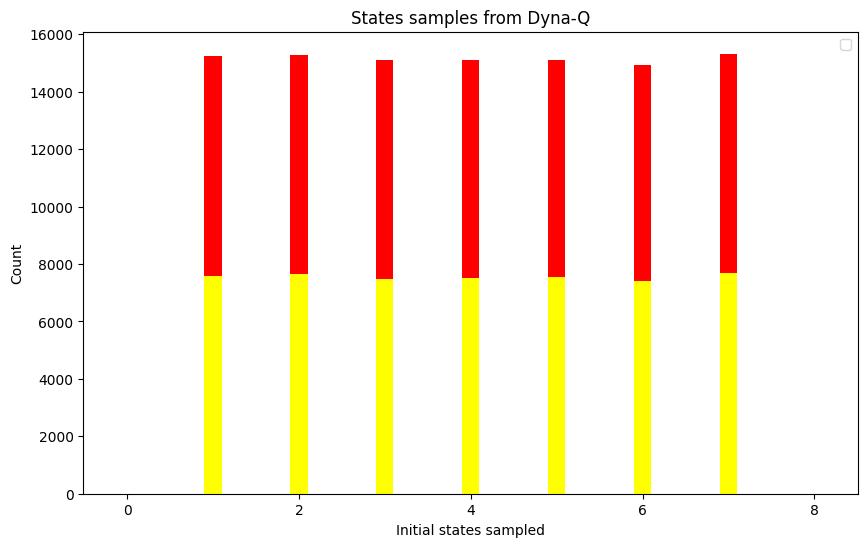

In [101]:
plot_state_action_sampling(planning_dyna, algo='Dyna-Q')

Notice that Dyna-Q samples uniformly at random, not only the states, but also the actions taken in those states.

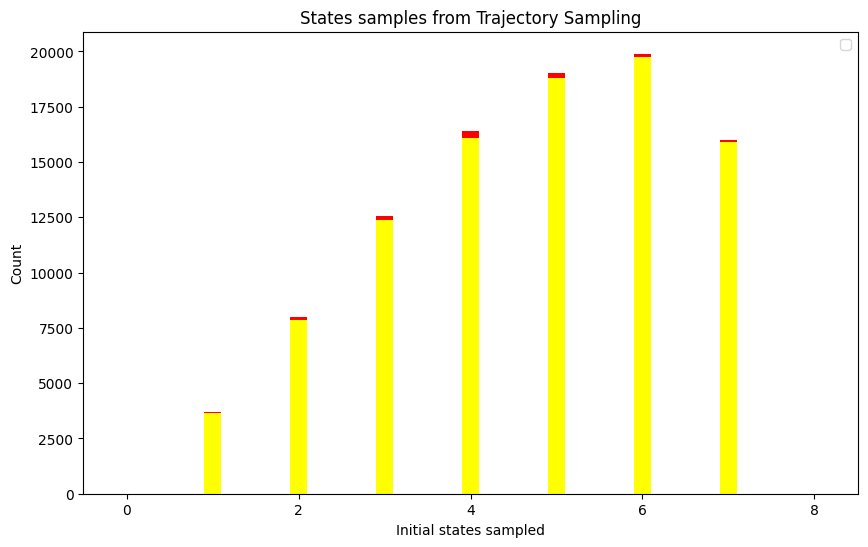

In [102]:
plot_state_action_sampling(planning_ts, algo='Trajectory Sampling')

Since the rightmost state is the only non-zero reward state, the greedy trajectory sampling strategy samples the model in an attempt to improve greedy action selection. This is the reason why the states sampled are skewed toward the goal state. The same happens with the sampling of the action. As we can see, the right action is sampled far more than the left action across the board. In that way, Trajectory Sampling **lands on the goal state far more often, therefore experiencing non-zero rewards from the model more frequently**.